In [1]:
import os

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import tensorflow as tf

config = tf.ConfigProto()
config.gpu_options.allow_growth=True

sess = tf.Session(config=config)

import numpy as np
import scipy
from PIL import Image
from matplotlib import pyplot as plt
from matplotlib import image
from vgg16_avg import VGG16_Avg
from keras import backend as K
from keras.models import Model
from keras import metrics
from scipy.misc import imsave
from scipy.optimize import fmin_l_bfgs_b

%matplotlib inline

Using TensorFlow backend.


In [2]:
image_dir = 'images/originals/'
image_height = 600
image_width = 600
fnames = os.listdir(image_dir)

#### Neural Style Transfer
We attempt to transfer the artistic style of an image (from that of another image), while trying to preserve the content of the original image. <br>
Original paper: [A Neural Algorithm of Artistic Style](https://arxiv.org/abs/1508.06576)

Load image and resize it so that both style and original image have same dimensions

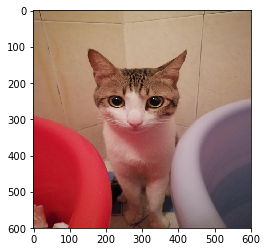

In [3]:
im = Image.open(image_dir+fnames[0])
im = im.resize((image_width, image_height), resample = Image.ANTIALIAS)
plt.imshow(im)

Pe-processing steps following in VGG paper:
- Flip RGB order to BGR
- subtract the mean of each channel of the imagenet data

Write 2 lambda functions - one to do the above pre-processing and one to undo the pre-processing;
The undo step is necessary in order to dispay the image correctly later

In [4]:
rn_mean = np.array([123.68, 116.779, 103.939], dtype=np.float32)

preproc = lambda x: (x - rn_mean)[:, :, :, ::-1]
deproc = lambda x,s: np.clip(x.reshape(s)[:, :, :, ::-1] + rn_mean, 0, 255)

In [5]:
img_arr = preproc(np.expand_dims(im, axis=0))
shp = img_arr.shape
shp

(1, 600, 600, 3)

#### Step 1: Re-create the input

The later layers of a CNN are known to store "meaning" of images rather than the specific details. 
So, we try to re-create the content of the image (the final CNN layer), starting from random noise. 

In [6]:
# Load the VGG model - re-designed with average pooling instead of MAX pooling
# Although the filter weights are kept the same
model = VGG16_Avg(include_top=False)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (AveragePooling2 (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (AveragePooling2 (None, None, None, 128)   0         
__________

Create a subset model, starting from the input to the final conv layer:

In [7]:
final_layer = model.get_layer('block4_conv1').output
layer_model = Model(model.input, final_layer)
targ = K.variable(layer_model.predict(img_arr))

In our implementation, we need to define an object that will allow us to separately access the loss function and gradients of a function, since that is what scikit-learn's optimizers require.

In [13]:
class Evaluator(object):
    def __init__(self, f, shp): 
        self.f, self.shp = f, shp
        
    def loss(self, x):
        loss_, self.grad_values = self.f([x.reshape(self.shp)])
        return loss_.astype(np.float64)

    def grads(self, x): 
        return self.grad_values.flatten().astype(np.float64)

In [8]:
from evaluator import Evaluator

In [9]:
# Loss is the MSE between the two ouput matrices at the specified convolution layer 
loss = K.mean(metrics.mse(final_layer, targ))
grads = K.gradients(loss, variables=model.input)
fn = K.function(inputs=[model.input], outputs=[loss]+grads)
evaluator = Evaluator(fn, shp)

Optimize the above loss function with a deterministic solver BFGS

In [10]:
def solve_image(eval_obj, n_iter, x):
    for i in range(n_iter):
        x, min_val, info = fmin_l_bfgs_b(eval_obj.loss, x.flatten(),
                                         fprime=eval_obj.grads, maxfun=20)
        x = np.clip(x, -127,127)
        print('Current loss value:', min_val)
        imsave(f'images/results/res_at_iteration_{i}.png', deproc(x.copy(), shp)[0])
    return x

Try different losses as starting point
- Random Normal
- Random Uniform

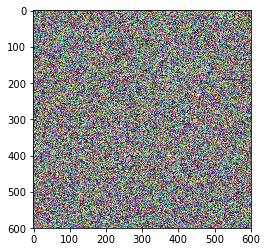

In [11]:
# We start from a random image and try to construct the 'image' at the end of the 5th conv layer
# rand_img = lambda shape: np.random.uniform(-2.5, 2.5, shape)/100
rand_img = lambda shape: np.random.normal(size=shape)
x = rand_img(shp) # Shape of x is 1 x image_w x image_h x n_channels
plt.imshow(x[0]); # x[0] is the image

In [12]:
iterations = 10
x = solve_image(evaluator, iterations, x)

Current loss value: 2123.74560547
Current loss value: 1243.28930664
Current loss value: 916.227111816
Current loss value: 747.797119141
Current loss value: 645.020629883
Current loss value: 565.226745605
Current loss value: 499.41619873
Current loss value: 448.169647217
Current loss value: 405.241333008
Current loss value: 371.077972412


See the image quality improving with iterations

In [19]:
from IPython.display import HTML
from matplotlib import animation, rc

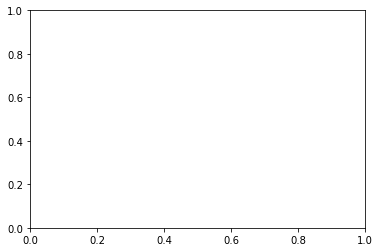

In [20]:
fig, ax = plt.subplots()
def animate(i): ax.imshow(Image.open(f'images/results/res_at_iteration_{i}.png'))

In [21]:
anim = animation.FuncAnimation(fig, animate, frames=10, interval=200)
HTML(anim.to_html5_video())

#### Step-2: Re-create the style
The above animation shows that we are able to somewhat capture the content of the image. Next we try to recreate the style

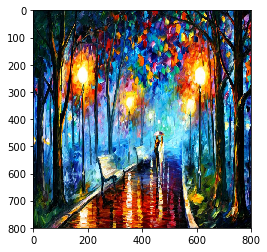

In [73]:
style = Image.open('images/styles/style_1.jpg')
style = style.resize((shp[1], shp[2]), resample = Image.ANTIALIAS)
plt.imshow(style)
style_arr = preproc(np.expand_dims(style,0)[:,:,:,:3])
shp = style_arr.shape

In [74]:
model = VGG16_Avg(include_top=False, input_shape=shp[1:])
outputs = {l.name: l.output for l in model.layers}

We consider the output from multiple convolutional layers instead of just the final one

In [75]:
layers = [outputs['block{}_conv1'.format(o)] for o in range(1,3)]
layers_model = Model(model.input, layers)
targs = [K.variable(o) for o in layers_model.predict(style_arr)]

Unlike previously for content loss, we do not directly calculate the MSE on the image pixels.
Instead here we compute the **gram matrix** of the image:
- the product of a matrix with its transpose: https://en.wikipedia.org/wiki/Gramian_matrix
- the reason it works was unknown until the recent paper - Demystifying Neural Style Transfer
- Supposedly, the gramian shows how our features at that convolutional layer correlate, and completely removes all location information. So matching the gram matrix of channels can only match some type of texture information, not location information.

In [76]:
def gram_matrix(x):
    # The first dim is #channels and second dimension is flattened image_w X image_h
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    # The dot product of this with its transpose shows the correlation 
    # between each pair of channels
    # For 3 channel, the output is 3x3
    return K.dot(features, K.transpose(features)) / x.get_shape().num_elements() 

In [77]:
def style_loss(x, targ): # MSE between the 2 gram matrices
    return K.mean(metrics.mse(gram_matrix(x), gram_matrix(targ))) 

In [78]:
loss = sum(style_loss(l1[0], l2[0]) for l1,l2 in zip(layers, targs))
grads = K.gradients(loss, model.input)
style_fn = K.function([model.input], [loss]+grads)
evaluator = Evaluator(style_fn, shp)

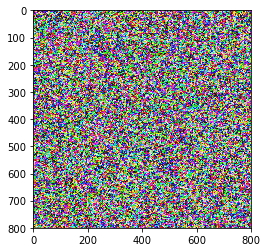

In [79]:
rand_img = lambda shape: np.random.uniform(-2.5, 2.5, shape)/1
x = rand_img(shp)
x = scipy.ndimage.filters.gaussian_filter(x, [0,2,2,0])
plt.imshow(x[0]);

In [80]:
iterations=10
x = rand_img(shp)

In [81]:
x = solve_image(evaluator, iterations, x)

Current loss value: 38523.3007812
Current loss value: 2936.6484375
Current loss value: 722.209533691
Current loss value: 432.24508667
Current loss value: 287.046142578
Current loss value: 198.822265625
Current loss value: 123.53553772
Current loss value: 82.2144851685
Current loss value: 56.9786834717
Current loss value: 40.114654541


#### Combine Style and Content losses

Style loss from all 5 layers (each given different weights), content loss only from last conv layer

In [82]:
w,h = style.size
src = img_arr[:,:h,:w]

In [83]:
style_layers = [outputs['block{}_conv2'.format(o)] for o in range(1,6)]
content_name = 'block4_conv1'
content_layer = outputs[content_name]

In [84]:
style_model = Model(model.input, style_layers)
style_targs = [K.variable(o) for o in style_model.predict(style_arr)]

In [85]:
content_model = Model(model.input, content_layer)
content_targ = K.variable(content_model.predict(src))

In [86]:
style_wgts = [0.05,0.2,0.2,0.25,0.3]

In [92]:
lambda_coeff = 10.0 # The weight given for content preservation
loss = sum(style_loss(l1[0], l2[0])*w
           for l1,l2,w in zip(style_layers, style_targs, style_wgts))
loss += lambda_coeff*K.mean(metrics.mse(content_layer, content_targ))
grads = K.gradients(loss, model.input)
transfer_fn = K.function([model.input], [loss]+grads)

In [93]:
evaluator = Evaluator(transfer_fn, shp)

In [94]:
iterations=10
x = rand_img(shp)

In [95]:
x = solve_image(evaluator, iterations, x)

Current loss value: 119655.984375
Current loss value: 72071.453125
Current loss value: 63810.78125
Current loss value: 59571.0351562
Current loss value: 57090.109375
Current loss value: 55198.96875
Current loss value: 53916.78125
Current loss value: 52852.9414062
Current loss value: 52031.9960938
Current loss value: 51265.8125


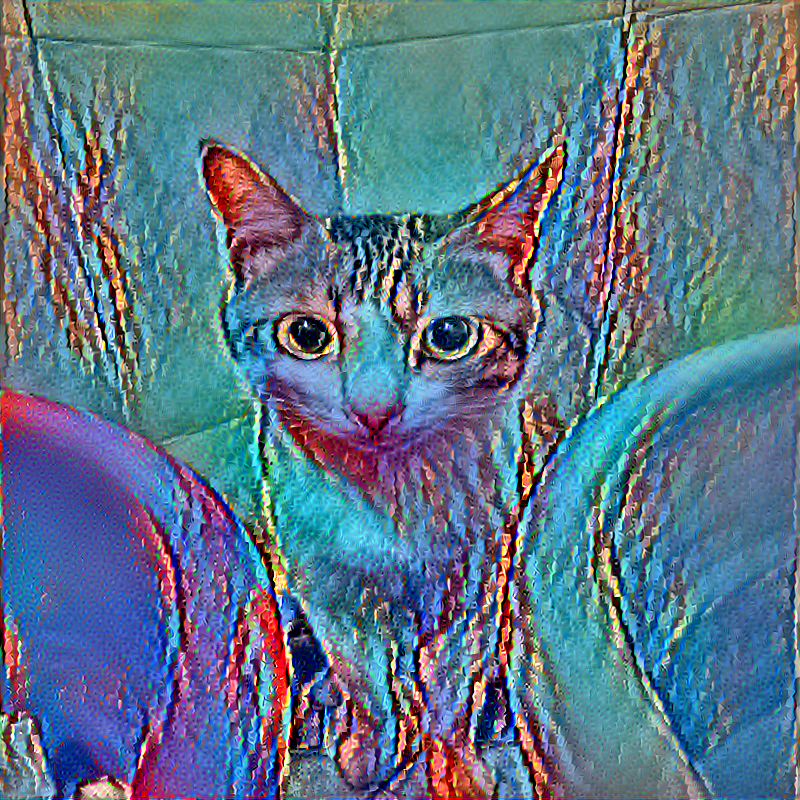

In [96]:
Image.open('images/results/res_at_iteration_9.png')